In [1]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
from collections import namedtuple, deque

import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import random
import roboschool
import matplotlib.pyplot as plt

In [4]:
H = 20
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(4, H)
        self.lin2 = nn.Linear(H, 2)
    
    def forward(self, x):
        x = F.relu(self.lin1(x))
        return F.softmax(self.lin2(x), dim=-1)

In [5]:
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
        return discounted_r
    
def prep_state(s):
    return Variable(torch.from_numpy(s).float().unsqueeze(0))

def to_tensor(l):
    return torch.from_numpy(np.asarray(l))

In [6]:
env = gym.make("CartPole-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [38]:
model = PolicyNetwork()
optimizer = torch.optim.RMSprop(model.parameters())

running_reward = None
num_episodes = 5000
gamma = 0.99 # discount factor for reward

for episode_number in range(num_episodes):
    rewards = []
    actions = []
    outputs = []
    done = False
    state = env.reset()
    reward_sum = 0
    
    while not done:
        if episode_number % 100 == 0:
            env.render()
        output = model(prep_state(state))
        action = 1 if random.random() < output.data[0,1] else 0
        state, reward, done, _ = env.step(action)
        reward_sum += reward
        rewards.append(reward)
        actions.append(torch.LongTensor([[action]]))
        outputs.append(output)
        
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    if episode_number % 100 == 0:
        print(running_reward)  
    
    discounted_rewards = Variable(torch.FloatTensor(discount_rewards(np.array(rewards))))
    
    actions = Variable(torch.cat(actions))
    probs = torch.cat(outputs).gather(1, actions)
    loss = torch.mean(discounted_rewards * torch.log(probs))
    loss.backward()
    if episode_number % 32 == 0:
        optimizer.step()
        optimizer.zero_grad()


20.0
19.87230682820147
30.706320027031104
44.862767672507815
53.56848809964372
59.1156799598485
61.712751807070916
68.40384503065718
68.89491504141591
81.85586260613924
92.48324674210147
107.43526064753243
126.20602820238888
138.03602394080397
149.2794898431134
150.7440581732776
156.7331639288185
160.17184953536886
167.14573570079475
167.56267901659248
176.82796887946247
177.69113333139023
174.96807455026197
176.97359757886252
179.25421163208512
187.7295318509598
190.20355462639836
186.804508731765
190.2930363604267
192.35051513867083
190.99088995412345
192.35766601696943
188.50405027355995
188.79077772784794
191.79547764696844
195.3703882622962
196.0128168294378
197.18623530285478
195.44490223580758
191.9558593717315
195.09744301944312
197.3065224990021
194.29927863538353
196.61320577944736
194.64198207679317
196.41647180198888
197.23268370297617
196.8515932040046
197.5268311383301
197.72429652591234


In [26]:
class PolicyGradient:
    def __init__(self, env, model):
        self.model = model
        self.env = env
        self.gamma = 0.999
        self.render = True
        
    def discount_rewards(self, r):
        """ take 1D float array of rewards and compute discounted reward """
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.gamma + r[t]
            discounted_r[t] = running_add
            return discounted_r

    def prep_state(self, s):
        return Variable(torch.from_numpy(s).float().unsqueeze(0))
    
    def train(self, num_episodes=5000):
        optimizer = torch.optim.RMSprop(self.model.parameters())
        running_reward = None
        gamma = 0.99 # discount factor for reward
        reward_sums = []

        for episode_number in range(num_episodes):
            rewards = []
            actions = []
            outputs = []
            done = False
            state = self.env.reset()
            reward_sum = 0

            while not done:
                if episode_number % 100 == 0 and self.render:
                    self.env.render()
                output = self.model(self.prep_state(state))
                action = 1 if random.random() < output.data[0,1] else 0
                state, reward, done, _ = self.env.step(action)
                reward_sum += reward
                rewards.append(reward)
                actions.append(torch.LongTensor([[action]]))
                outputs.append(output)

            reward_sums.append(reward_sum)
            running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
            if episode_number % 100 == 0:
                print(running_reward)  

            discounted_rewards = Variable(torch.FloatTensor(self.discount_rewards(np.array(rewards))))

            actions = Variable(torch.cat(actions))
            probs = torch.cat(outputs).gather(1, actions)
            loss = torch.mean(discounted_rewards * torch.log(probs))
            loss.backward()
            if episode_number % 32 == 0:
                optimizer.step()
                optimizer.zero_grad()
        return reward_sums

In [27]:
model = PolicyNetwork()
pg = PolicyGradient(env, model)

In [23]:
rewards = pg.train(2000)

60.0
49.53791984098626
55.10174386678715
63.96510586087324
74.52363876049746
93.61514412529061
125.70817333438852
148.65743808543854
159.95118884835205
174.13174931082315
180.47681416474327
182.09704132553574
181.0012914964994
186.09552128670927
191.72237379829284
195.2466306820776
194.21691553952394
197.25770051023687
195.71709274375218
197.477918172532


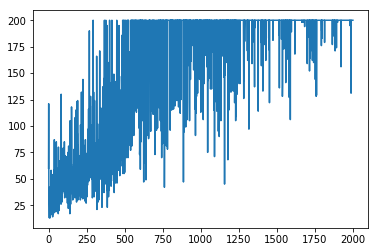

In [25]:
plt.plot(rewards)

In [48]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))
Batch = namedtuple('Batch', ('states', 'actions', 'rewards', 'next_states'))

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque([], maxlen=capacity)
    
    def add(self, *args):
        """Saves a transition."""
        self.memory.append(Transition(*args))
    
    def sample_batch(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        batch = Batch(*zip(*transitions))
        states = torch.cat(batch.states)
        actions = torch.cat(batch.actions)
        rewards = Variable(torch.cat(batch.rewards).unsqueeze(1))
        next_states = torch.cat(batch.next_states)
        return Batch(states, actions, rewards, next_states)
    
    def __len__(self):
        return len(self.memory)

class RandomProcess:
    def __init__(self, shape, theta=0.15, sigma=0.2):
        self.theta = theta
        self.mu = 0
        self.sigma = sigma
        self.last = 0
        self.shape = np.atleast_1d(shape)
    
    def sample(self):
        self.last = self.last + self.theta * (self.mu - self.last) + self.sigma * np.random.randn(*self.shape)
        return self.last
    
    def reset(self):
        self.last = 0

class DDPG:
    def __init__(self, env, actor_model, critic_model):
        self.env = env
        self.actor = actor_model
        self.actor_target = actor_model.clone()
        self.critic = critic_model
        self.critic_target = critic_model.clone()
        self.capacity = 10000
        self.memory = ReplayMemory(self.capacity)
        self.batch_size = 500
        self.gamma = 0.999
        self.tau = 0.1
        self.random_process = RandomProcess(env.action_space.shape[0])
        
        self.optim_critic = optim.RMSprop(self.critic.parameters())
        self.optim_actor = optim.RMSprop(self.actor.parameters())
        self.render = 100
        
    def update(self, target, source):
        zipped = zip(target.parameters(), source.parameters())
        for target_param, source_param in zipped:
            updated_param = target_param.data * (1 - self.tau) + source_param.data * self.tau
            target_param.data.copy_(updated_param)    
        
    def train_models(self):
        if len(self.memory) < self.batch_size:
            return None, None
        mini_batch = self.memory.sample_batch(self.batch_size)
        critic_loss = self.train_critic(mini_batch)
        actor_loss = self.train_actor(mini_batch)
        self.update(self.actor_target, self.actor)
        self.update(self.critic_target, self.critic)
        return critic_loss.data[0], actor_loss.data[0]

    def mse(self, inputs, targets):
        return torch.mean((inputs - targets)**2)
        
    def train_critic(self, batch):
        # forward pass
        pred_actions = self.actor_target(batch.next_states)
        target_q = batch.rewards + self.critic_target([batch.next_states, pred_actions]) * self.gamma
        pred_q = self.critic([batch.states, batch.actions])
        target_q = target_q.detach()
        #backward pass
#         loss = F.smooth_l1_loss(pred_q, target_q)
        loss = self.mse(pred_q, target_q)
        self.optim_critic.zero_grad()
        loss.backward(retain_graph=True)
        for param in self.critic.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optim_critic.step()
        return loss

    def train_actor(self, batch):        
        # forward pass
        pred_mu = self.actor(batch.states)
        pred_q = self.critic([batch.states, pred_mu])
        # backward pass
        loss = (pred_q).mean()
        self.optim_actor.zero_grad()
        loss.backward()
        for param in self.actor.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optim_actor.step()
        return loss
        
    def prep_state(self, s):
        return Variable(torch.from_numpy(s).float().unsqueeze(0))
        
    def select_action(self, state, exploration=True):
        action = self.actor(state)
        if exploration:
            noise = self.random_process.sample()
            action = action + Variable(torch.from_numpy(noise).float())
        return action
    
    def train(self, num_episodes):
        running_reward = None
        reward_sums = []
        losses = []

        for episode_number in range(num_episodes):
            done = False
            state = self.prep_state(self.env.reset())
            reward_sum = 0
            self.random_process.reset()

            while not done:
                if self.render is not None and episode_number % self.render == 0:
                    self.env.render()
                action = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action.data.numpy()[0])
                next_state = self.prep_state(next_state)
                reward = torch.FloatTensor([reward])
                self.memory.add(state, action, reward, next_state)
                state = next_state
                reward_sum += reward[0]
                losses.append(self.train_models())

            reward_sums.append(reward_sum)
            running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
            
            if episode_number % 100 == 0:
                print(running_reward)  
            
        return reward_sums, losses

    def run(self, render=True):
        state = self.env.reset()
        done = False
        reward_sum = 0
        while not done:
            if render:
                self.env.render()
            action = self.select_action(self.prep_state(state), exploration=False)
            state, reward, done, _ = self.env.step(action.data[0])
            reward_sum += reward
        return reward_sum

In [41]:
class Cloneable:
    def clone(self):
        assert self.args
        model_clone = self.__class__(*self.args)
        model_clone.load_state_dict(self.state_dict())
        model_clone.train(False)
        return model_clone

class Actor(nn.Module, Cloneable):
    def __init__(self, n_states, n_actions, n_hidden):
        super().__init__()
        self.args = (n_states, n_actions, n_hidden)
        self.lin1 = nn.Linear(n_states, n_hidden)
        self.lin2 = nn.Linear(n_hidden, n_hidden)
        self.lin3 = nn.Linear(n_hidden, n_actions)
        
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.tanh(self.lin3(x))
        return x

class Critic(nn.Module, Cloneable):
    def __init__(self, n_states, n_actions, n_hidden):
        super().__init__()
        self.args = (n_states, n_actions, n_hidden)
        self.lin_states = nn.Linear(n_states, n_hidden)
        self.lin1 = nn.Linear(n_hidden + n_actions, n_hidden)
        self.lin2 = nn.Linear(n_hidden, 1)
    
    def forward(self, x):
        s, a = x
        states_hidden = F.relu(self.lin_states(s))
        x = F.relu(self.lin1(torch.cat([states_hidden, a], 1)))
        x = self.lin2(x)
        return x
        

In [49]:
env = gym.make('RoboschoolInvertedPendulum-v1')
n_states = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
actor = Actor(n_states, n_actions, 40)
critic = Critic(n_states, n_actions, 40)
try:
    ddpg = DDPG(env, actor, critic)
    rewards, losses = ddpg.train(100)
finally:
    env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
10.0


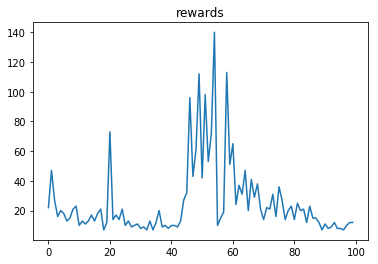

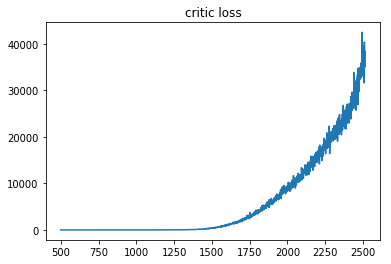

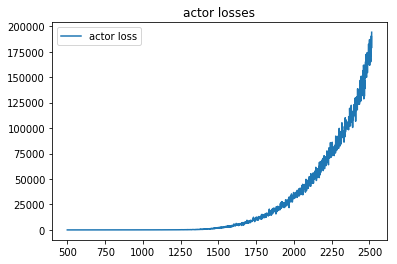

In [47]:
plt.plot(rewards)
plt.title('rewards')
plt.show()

losses = np.array(losses)
plt.plot(losses[:,0],label='critic loss')
plt.title('critic loss')
plt.show()
plt.plot(losses[:,1],label='actor loss')
plt.title('actor losses')
plt.legend()
plt.show()

In [108]:
x = torch.mean(torch.arange(1,10)**2)

In [5]:
env = gym.make('RoboschoolInvertedPendulumSwingup-v1')
ddpg = DDPG(env, actor_pendulum, critic_pendulum)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


NameError: name 'actor_pendulum' is not defined

In [261]:
env.close()

In [260]:
ddpg.run()

1000.0

In [158]:
actor_pendulum = actor

In [159]:
critic_pendulum = critic

In [216]:
r = RandomProcess(3)

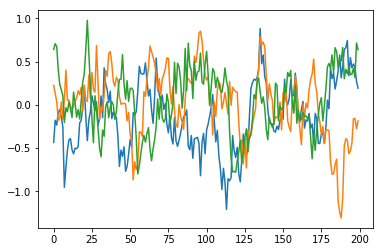

In [240]:
a,b,c = [],[],[]
for _ in range(200):
    s = r.sample()
    a.append(s[0])
    b.append(s[1])
    c.append(s[2])
plt.plot(a)
plt.plot(b)
plt.plot(c)

In [211]:
np.atleast_1d((1))

array([1])